# Comparison of True Air Speed between UND instrumentation vs NSRC P-3 Values

- ORACLES 2016 had similar pylon configuration throughout the campaign. 
- After 2016, the CAPS instrument was moved ahead of the leading edge of the aircraft. 
- This analysis checks if this movement if evident within the dataset. 

In [4]:
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

from scipy.stats.mstats import pearsonr
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [5]:
def oracles_read(nfiles, nvar='Mach_Number'):

    def select_vars(obj, nvar=nvar):
        dedup = obj
        # create a list of all variables in the dataset
        newlist = [x for x in dedup.keys() if x != 'P3_module_flags']
        # drop everything but input variables
        droplist = [y for y in newlist if y != nvar]
        # remove all other variables
        dedup = dedup.drop_vars(droplist)
        # Clean up dimensions
        ndims = [x for x in dedup.dims if x != 'time']
        # remove all extra dimensions
        dedup = dedup.drop_dims(ndims)
        return dedup
    
    # Read in all the ORACLEs 2018 data with ACT
    ds = xr.open_mfdataset(nfiles,
                           coords='minimal',
                           preprocess=select_vars
                          )
    
    return ds
    

In [6]:
def define_profile(obj, nvar):
    """ return subset of sawtooth and cloud profiles for given variable """
    # Define the Sawtooth periods
    list_saw = np.where(obj['P3_module_flags'].data.compute() == 5)
    list_cl = np.where(obj['P3_module_flags'].data.compute() == 1)
    #saw = np.where(obj[nvar].data.compute() != np.isnan)
    saw = np.ma.masked_invalid(obj[nvar][list_saw].to_numpy())
    cl = np.ma.masked_invalid(obj[nvar][list_cl].to_numpy())
    ### Subset the Variable
    ##nvar_saw_list = [x for x in obj[nvar][saw].data[:].compute() if np.isnan(x) == False ]
    ##nvar_cl_list = [x for x in obj[nvar][cl].data[:].compute() if np.isnan(x) == False ]  
    # dump MVC
    ##nvar_saw = [x for x in nvar_saw_list if x < 1e36]
    ##nvar_cl  = [x for x in nvar_cl_list if x < 1e36]
    #nvar_saw = np.intersect1d(saw, valid)
    #nvar_cl = np.intersect1d(cl, valid)
    
    return saw, cl

In [7]:
def violin_plot(obj,
                axarr,
                year='2018',
                nvar='Mach_Number',
                ):
    """
    Violin plot to subset Sawtooth and Level Cloud leg profiles
    for a given variable and campaign. 

    Inputs
    ------

    obj : xarray mf_dataset
        must contain nvar as a DataArray, along with P3 Modules
    axarr : matplotlib axe 
        matplotlib suplot axe to plot into
    year : string
        string containing year of project
    pos : list
        list containing intergers for location to plot violins
    nvar : string
        variable to display

    Returns
    ------
    figure of violin plots
    """

    if nvar == 'True_Air_Speed':
        ylabel = 'True Air Speed [knots]'
    elif nvar == 'Static_Air_Temp':
        ylabel = 'Static Air Temperature [degree Celcius]'
    elif nvar == 'Static_Pressure':
        ylabel = 'Static Pressure [hPa]'
    elif nvar == 'CIP_TAS':
        ylabel = 'CAPS Pitot TAS [m/s]'
    else:
        ylabel = 'P3 Mach Number [#]'

    # Define the Sawtooth periods
    saw = np.where(obj['P3_module_flags'].data.compute() == 5)
    cl = np.where(obj['P3_module_flags'].data.compute() == 1)
    # Subset the Variable
    nvar_saw_list = [x for x in obj[nvar][saw].data[:].compute() if np.isnan(x) == False ]
    nvar_cl_list = [x for x in obj[nvar][cl].data[:].compute() if np.isnan(x) == False ]  
    # dump MVC
    nvar_saw = [x for x in nvar_saw_list if x < 1e36]
    nvar_cl  = [x for x in nvar_cl_list if x < 1e36]
    # Define all the tick labels for the plots
    tick_label = ['',
                  '2016 \n Sawtooth', 
                  '2016 \n Cloud', 
                  '2017 \n Sawtooth', 
                  '2017 \n Cloud', 
                  '2018 \n Sawtooth', 
                  '2018 \n Cloud',
                  ]

    if year == '2016':
        npos = [1, 2]
    elif year == '2017':
        npos = [3, 4]
    elif year == '2018':
        npos = [5, 6]
    else:
        npos = [0, 7]
    
    sc = axarr.violinplot(np.array(nvar_saw),
                       positions=[npos[0]],
                       vert=True,
                       showmeans=True,
                       showmedians=True,
                       showextrema=True
                      )

    sc2 = axarr.violinplot(np.array(nvar_cl),
                        positions=[npos[1]],
                        vert=True,
                        showmeans=True,
                        showmedians=True,
                        showextrema=True
                       )

    # Label the means/medians
    for partname in ('cbars','cmins','cmaxes'):
        sc[partname].set_edgecolor('cornflowerblue')
        sc2[partname].set_edgecolor('cornflowerblue')
    sc['cmeans'].set_edgecolor('red')
    sc['cmedians'].set_edgecolor('black')
    sc2['cmeans'].set_edgecolor('red')
    sc2['cmedians'].set_edgecolor('black')
    # Change the color of the body
    for pc in sc['bodies']:
       pc.set_facecolor('thistle')
       pc.set_edgecolor('black')
       pc.set_alpha(1)
    for vc in sc2['bodies']:
       vc.set_facecolor('thistle')
       vc.set_edgecolor('black')
       vc.set_alpha(1)

    # Set the title
    axarr.set_ylabel(ylabel)
    # Set the background color
    axarr.axvspan(4.5, 7, color='lightblue', zorder=-1, alpha=0.4)
    axarr.axvspan(2.5, 4.5, color='sandybrown', zorder=-1, alpha=0.4)
    # set ticks
    axarr.set_xticks([0, 1, 2, 3, 4, 5, 6])
    axarr.set_xticklabels(tick_label)
    axarr.set_xlim([0.5, 6.5])
    axarr.set_title('ORACLES In-Situ Cloud Environmental Conditions')

    return axarr

In [8]:
def alpha(nvar='Mach_Number'):
    # locate all the ORACLES 2018 data
    file_list_2018 = sorted(glob.glob('/Users/jrobrien/Dissertation/data/oracles_merge/mrg1*2018*'))
    file_list_2017 = sorted(glob.glob('/Users/jrobrien/Dissertation/data/oracles_merge/mrg1*2017*'))
    file_list_2016 = sorted(glob.glob('/Users/jrobrien/Dissertation/data/oracles_merge/mrg1*2016*'))
    # read in all the ORACLES data
    ds2018 = oracles_read(file_list_2018, nvar=nvar)
    ds2017 = oracles_read(file_list_2017, nvar=nvar)
    ds2016 = oracles_read(file_list_2016, nvar=nvar)

    # create the plot
    # Plot the Mach Number violin plot for 2018
    fig, axarr = plt.subplots(1, 1, figsize=[12, 8])

    violin_plot(ds2016,
                axarr,
                year='2016',
                nvar=nvar)

    violin_plot(ds2017,
                axarr,
                year='2017',
                nvar=nvar)

    violin_plot(ds2018,
                axarr,
                year='2018',
                nvar=nvar)
    
#if __name__ == '__main__':
#    # call the main function
#    main(nvar='CIP_TAS')

In [9]:
# locate all the ORACLES 2018 data
file_list_2018 = sorted(glob.glob('/Users/jrobrien/Dissertation/data/oracles_merge/mrg1*2018*'))
file_list_2017 = sorted(glob.glob('/Users/jrobrien/Dissertation/data/oracles_merge/mrg1*2017*'))
file_list_2016 = sorted(glob.glob('/Users/jrobrien/Dissertation/data/oracles_merge/mrg1*2016*'))
# read in all the ORACLES CIP TAS data
cip_2018 = oracles_read(file_list_2018, nvar='CIP_TAS')
cip_2017 = oracles_read(file_list_2017, nvar='CIP_TAS')
cip_2016 = oracles_read(file_list_2016, nvar='CIP_TAS')
# read in all the ORACLES P-3 Aircraf TAS
tas_2018 = oracles_read(file_list_2018, nvar='Sys_TAS')
tas_2017 = oracles_read(file_list_2017, nvar='Sys_TAS')
tas_2016 = oracles_read(file_list_2016, nvar='Sys_TAS')
# read in all the WINDS Pitch Data
pitch_2018 = oracles_read(file_list_2018, nvar='WINDS_Pitch_deg')
pitch_2017 = oracles_read(file_list_2017, nvar='WINDS_Pitch_deg')
pitch_2016 = oracles_read(file_list_2016, nvar='WINDS_Pitch_deg')
# read in all the ORACLES CAS LWC data
cas_lwc_2018 = oracles_read(file_list_2018, nvar='CAS_LWC')
cas_lwc_2017 = oracles_read(file_list_2017, nvar='CAS_LWC')
cas_lwc_2016 = oracles_read(file_list_2016, nvar='CAS_LWC')
# read in all the ORACLES P-3 Aircraf TAS
cas_nt_2018 = oracles_read(file_list_2018, nvar='CASNtCloud')
cas_nt_2017 = oracles_read(file_list_2017, nvar='CASNtCloud')
cas_nt_2016 = oracles_read(file_list_2016, nvar='CASNtCloud')
# read in all the WINDS Pitch Data
king_2018 = oracles_read(file_list_2018, nvar='King_LWC_ad')
king_2017 = oracles_read(file_list_2017, nvar='King_LWC_ad')
king_2016 = oracles_read(file_list_2016, nvar='King_LWC_ad')

[ 0.90451164 -9.00156243]
[ 0.90130977 -9.18320511]
[0.77910793 0.83228783]
[0.74284195 4.8402678 ]
[0.74186483 5.85021561]
[0.74611157 5.34460099]


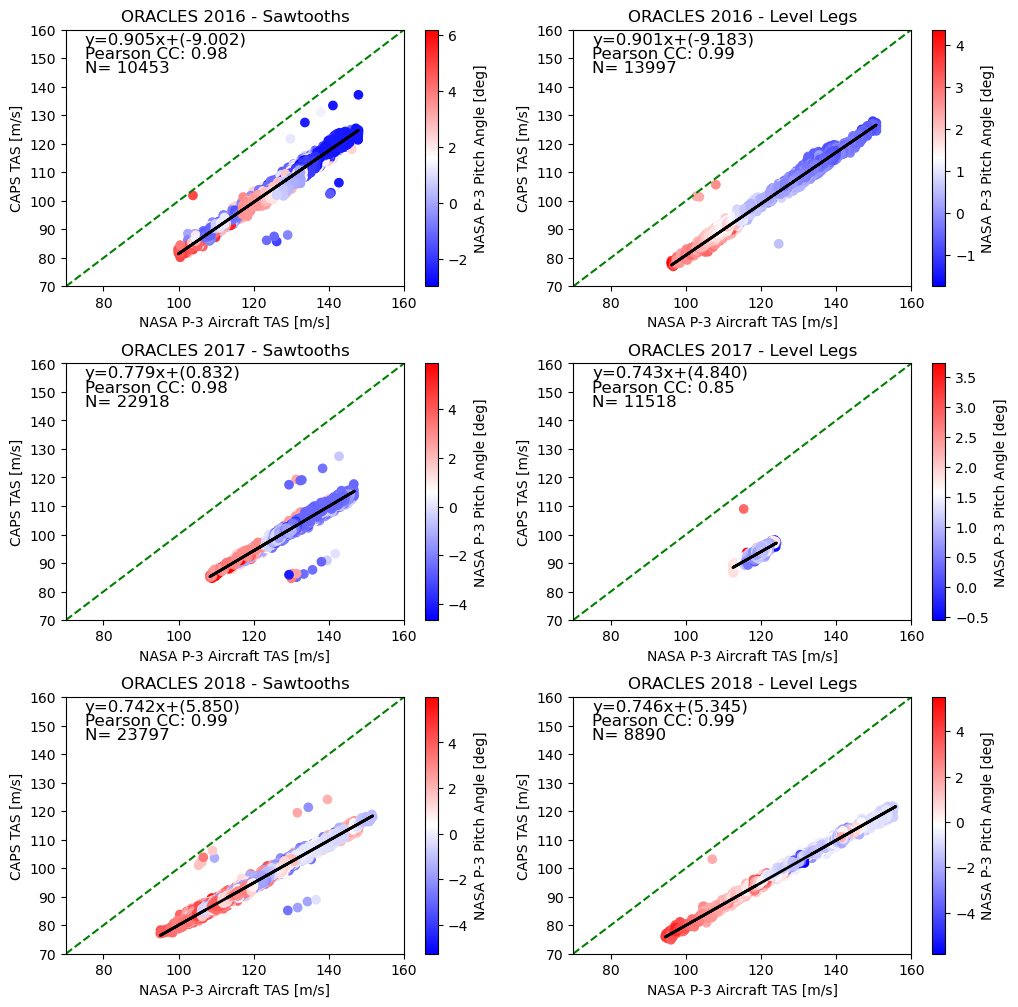

In [22]:
# Define the total plot
fig, ax2 = plt.subplots(3, 2, figsize=[12, 12])
# adjust the space
plt.subplots_adjust(hspace=0.3, wspace=0.2)

#--------
# 2016
#--------

# Define the profiles
cip_saw_2016, cip_cl_2016 = define_profile(cip_2016, 'CIP_TAS')
p3_saw_2016, p3_cl_2016 = define_profile(tas_2016, 'Sys_TAS')
pitch_saw_2016, pitch_cl_2016 = define_profile(pitch_2016, 'WINDS_Pitch_deg')

# Plot the 2018 Sawtooth Data
psaw_2016 = ax2[0, 0].scatter(p3_saw_2016, cip_saw_2016, c=pitch_saw_2016, cmap='bwr')
# Define the labels
ax2[0, 0].set_xlabel('NASA P-3 Aircraft TAS [m/s]')
ax2[0, 0].set_ylabel('CAPS TAS [m/s]')
# Set the limits, use for 1:1 Ratio line
ax2[0, 0].set_xlim([70, 160])
ax2[0, 0].set_ylim([70, 160])
# Define the one to one line
ratio = np.linspace(70, 160)
ax2[0, 0].plot(ratio, ratio, 'g--')
# Best fit line
z = np.ma.polyfit(p3_saw_2016, cip_saw_2016, 1)
print(z)
p = np.poly1d(z)
ax2[0, 0].plot(p3_saw_2016, p(p3_saw_2016),"k-",linewidth=2)
# Display the line equation
# the line equation:
ax2[0, 0].text(75,155,"y=%.3fx+(%.3f)"%(z[0],z[1]),fontsize=12)
# Define title
ax2[0, 0].set_title('ORACLES 2016 - Sawtooths')
# Calculate Pearson Coefficient
cc_conc = pearsonr(p3_saw_2016, cip_saw_2016)
ax2[0, 0].text(75,150,"Pearson CC: %.2f"%(cc_conc[0]),fontsize=12)
ax2[0, 0].text(75,145,"N= %.0f"%(len(cip_saw_2016)),fontsize=12)
# Root Mean Square Error
#rms = mean_squared_error(p3_saw_2016, cip_saw_2016, squared=False)
#n = len(predictions)
#rmse = np.ma.linalg.norm(p3_saw_2016 - cip_saw_2016) / np.sqrt(len(p3_saw_2016))
#print(rmse)
# Define the colorbar
plt.colorbar(psaw_2016, ax=ax2[0, 0], label='NASA P-3 Pitch Angle [deg]')

# Plot the 2018 Cloud Data
pcl_2016 = ax2[0, 1].scatter(p3_cl_2016, cip_cl_2016, c=pitch_cl_2016, cmap='bwr')
# Define the labels
ax2[0, 1].set_xlabel('NASA P-3 Aircraft TAS [m/s]')
ax2[0, 1].set_ylabel('CAPS TAS [m/s]')
# Set the limits, use for 1:1 Ratio line
ax2[0, 1].set_xlim([70, 160])
ax2[0, 1].set_ylim([70, 160])
# Define the one to one line
ratio = np.linspace(70, 160)
ax2[0, 1].plot(ratio, ratio, 'g--')
# Best fit line
z2 = np.ma.polyfit(p3_cl_2016, cip_cl_2016, 1)
print(z2)
p = np.poly1d(z2)
ax2[0, 1].plot(p3_cl_2016, p(p3_cl_2016),"k-",linewidth=2)
# Display the line equation
# the line equation:
ax2[0, 1].text(75, 155, "y=%.3fx+(%.3f)" % (z2[0], z2[1]),fontsize=12)
# Define title
ax2[0, 1].set_title('ORACLES 2016 - Level Legs')
# Calculate Pearson Coefficient
cc_conc = pearsonr(p3_cl_2016, cip_cl_2016)
ax2[0, 1].text(75,150,"Pearson CC: %.2f"%(cc_conc[0]),fontsize=12)
ax2[0, 1].text(75,145,"N= %.0f"%(len(cip_cl_2016)),fontsize=12)
# Define the colorbar
plt.colorbar(pcl_2016, ax=ax2[0, 1], label='NASA P-3 Pitch Angle [deg]')


#--------
# 2017
#--------

# Define the profiles
cip_saw_2017, cip_cl_2017 = define_profile(cip_2017, 'CIP_TAS')
p3_saw_2017, p3_cl_2017 = define_profile(tas_2017, 'Sys_TAS')
pitch_saw_2017, pitch_cl_2017 = define_profile(pitch_2017, 'WINDS_Pitch_deg')

# Plot the 2018 Sawtooth Data
psaw_2017 = ax2[1, 0].scatter(p3_saw_2017, cip_saw_2017, c=pitch_saw_2017, cmap='bwr')
# Define the labels
ax2[1, 0].set_xlabel('NASA P-3 Aircraft TAS [m/s]')
ax2[1, 0].set_ylabel('CAPS TAS [m/s]')
# Set the limits, use for 1:1 Ratio line
ax2[1, 0].set_xlim([70, 160])
ax2[1, 0].set_ylim([70, 160])
# Define the one to one line
ratio = np.linspace(70, 160)
ax2[1, 0].plot(ratio, ratio, 'g--')
# Best fit line
z = np.ma.polyfit(p3_saw_2017, cip_saw_2017, 1)
print(z)
p = np.poly1d(z)
ax2[1, 0].plot(p3_saw_2017, p(p3_saw_2017),"k-",linewidth=2)
# Display the line equation
# the line equation:
ax2[1, 0].text(75,155,"y=%.3fx+(%.3f)"%(z[0],z[1]),fontsize=12)
# Define title
ax2[1, 0].set_title('ORACLES 2017 - Sawtooths')
# Calculate Pearson Coefficient
cc_conc = pearsonr(p3_saw_2017, cip_saw_2017)
ax2[1, 0].text(75,150,"Pearson CC: %.2f"%(cc_conc[0]),fontsize=12)
ax2[1, 0].text(75,145,"N= %.0f"%(len(cip_saw_2017)),fontsize=12)
# Define the colorbar
plt.colorbar(psaw_2017, ax=ax2[1, 0], label='NASA P-3 Pitch Angle [deg]')

# Plot the 2018 Cloud Data
pcl_2017 = ax2[1, 1].scatter(p3_cl_2017, cip_cl_2017, c=pitch_cl_2017, cmap='bwr')
# Define the labels
ax2[1, 1].set_xlabel('NASA P-3 Aircraft TAS [m/s]')
ax2[1, 1].set_ylabel('CAPS TAS [m/s]')
# Set the limits, use for 1:1 Ratio line
ax2[1, 1].set_xlim([70, 160])
ax2[1, 1].set_ylim([70, 160])
# Define the one to one line
ratio = np.linspace(70, 160)
ax2[1, 1].plot(ratio, ratio, 'g--')
# Best fit line
z2 = np.ma.polyfit(p3_cl_2017, cip_cl_2017, 1)
print(z2)
p = np.poly1d(z2)
ax2[1, 1].plot(p3_cl_2017, p(p3_cl_2017),"k-",linewidth=2)
# Display the line equation
# the line equation:
ax2[1, 1].text(75, 155, "y=%.3fx+(%.3f)" % (z2[0], z2[1]),fontsize=12)
# Define title
ax2[1, 1].set_title('ORACLES 2017 - Level Legs')
# Calculate Pearson Coefficient
cc_conc = pearsonr(p3_cl_2017, cip_cl_2017)
ax2[1, 1].text(75, 150,"Pearson CC: %.2f"%(cc_conc[0]),fontsize=12)
ax2[1, 1].text(75, 145,"N= %.0f"%(len(cip_cl_2017)),fontsize=12)
# Define the colorbar
plt.colorbar(pcl_2017, ax=ax2[1, 1], label='NASA P-3 Pitch Angle [deg]')


#--------
# 2018
#--------

# Define the profiles
cip_saw_2018, cip_cl_2018 = define_profile(cip_2018, 'CIP_TAS')
p3_saw_2018, p3_cl_2018 = define_profile(tas_2018, 'Sys_TAS')
pitch_saw_2018, pitch_cl_2018 = define_profile(pitch_2018, 'WINDS_Pitch_deg')

# Plot the 2018 Sawtooth Data
psaw_2018 = ax2[2, 0].scatter(p3_saw_2018, cip_saw_2018, c=pitch_saw_2018, cmap='bwr')
# Define the labels
ax2[2, 0].set_xlabel('NASA P-3 Aircraft TAS [m/s]')
ax2[2, 0].set_ylabel('CAPS TAS [m/s]')
# Set the limits, use for 1:1 Ratio line
ax2[2, 0].set_xlim([70, 160])
ax2[2, 0].set_ylim([70, 160])
# Define the one to one line
ratio = np.linspace(70, 160)
ax2[2, 0].plot(ratio, ratio, 'g--')
# Best fit line
z = np.ma.polyfit(p3_saw_2018, cip_saw_2018, 1)
print(z)
p = np.poly1d(z)
ax2[2, 0].plot(p3_saw_2018,p(p3_saw_2018),"k-",linewidth=2)
# Display the line equation
# the line equation:
ax2[2, 0].text(75,155,"y=%.3fx+(%.3f)"%(z[0],z[1]),fontsize=12)
# Define title
ax2[2, 0].set_title('ORACLES 2018 - Sawtooths')
# Calculate Pearson Coefficient
cc_conc = pearsonr(p3_saw_2018, cip_saw_2018)
ax2[2, 0].text(75, 150,"Pearson CC: %.2f"%(cc_conc[0]),fontsize=12)
ax2[2, 0].text(75, 145,"N= %.0f"%(len(cip_saw_2018)),fontsize=12)
# Define the colorbar
plt.colorbar(psaw_2018, ax=ax2[2, 0], label='NASA P-3 Pitch Angle [deg]')

# Plot the 2018 Cloud Data
pcl_2018 = ax2[2, 1].scatter(p3_cl_2018, cip_cl_2018, c=pitch_cl_2018, cmap='bwr')
# Define the labels
ax2[2, 1].set_xlabel('NASA P-3 Aircraft TAS [m/s]')
ax2[2, 1].set_ylabel('CAPS TAS [m/s]')
# Set the limits, use for 1:1 Ratio line
ax2[2, 1].set_xlim([70, 160])
ax2[2, 1].set_ylim([70, 160])
# Define the one to one line
ratio = np.linspace(70, 160)
ax2[2, 1].plot(ratio, ratio, 'g--')
# Best fit line
z2 = np.ma.polyfit(p3_cl_2018, cip_cl_2018, 1)
print(z2)
p = np.poly1d(z2)
ax2[2, 1].plot(p3_cl_2018,p(p3_cl_2018),"k-",linewidth=2)
# Display the line equation
# the line equation:
ax2[2, 1].text(75,155,"y=%.3fx+(%.3f)"%(z2[0],z2[1]),fontsize=12)
# Define title
ax2[2, 1].set_title('ORACLES 2018 - Level Legs')
# Calculate Pearson Coefficient
cc_conc = pearsonr(p3_cl_2018, cip_cl_2018)
ax2[2, 1].text(75, 150,"Pearson CC: %.2f"%(cc_conc[0]),fontsize=12)
ax2[2, 1].text(75, 145,"N= %.0f"%(len(cip_cl_2018)),fontsize=12)
# Define the colorbar
plt.colorbar(pcl_2018, ax=ax2[2, 1], label='NASA P-3 Pitch Angle [deg]')

plt.savefig('oracles-tas-comparison.png')

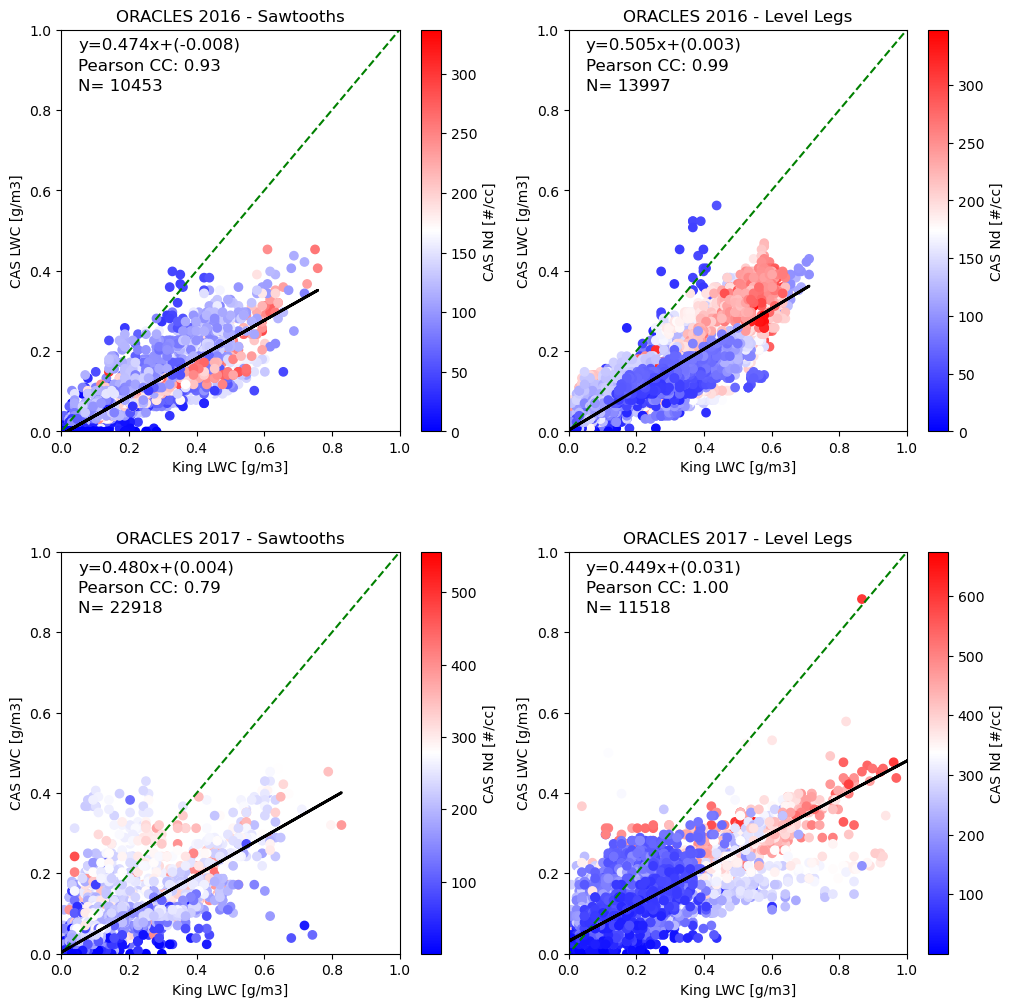

In [25]:
# Define the total plot
fig, ax2 = plt.subplots(2, 2, figsize=[12, 12])
# adjust the space
plt.subplots_adjust(hspace=0.3, wspace=0.2)

#--------
# 2016
#--------

# Define the profiles
caslwc_saw_2016, caslwc_cl_2016 = define_profile(cas_lwc_2016, 'CAS_LWC')
king_saw_2016, king_cl_2016 = define_profile(king_2016, 'King_LWC_ad')
casnd_saw_2016, casnd_cl_2016 = define_profile(cas_nt_2016, 'CASNtCloud')

# Plot the 2018 Sawtooth Data
psaw_2016 = ax2[0, 0].scatter(king_saw_2016, caslwc_saw_2016, c=casnd_saw_2016, cmap='bwr')
# Define the labels
ax2[0, 0].set_xlabel('King LWC [g/m3]')
ax2[0, 0].set_ylabel('CAS LWC [g/m3]')
# Set the limits, use for 1:1 Ratio line
ax2[0, 0].set_xlim([0, 1])
ax2[0, 0].set_ylim([0, 1])
# Define the one to one line
ratio = np.linspace(-1, 10)
ax2[0, 0].plot(ratio, ratio, 'g--')
# Best fit line
z = np.ma.polyfit(king_saw_2016, caslwc_saw_2016, 1)
p = np.poly1d(z)
ax2[0, 0].plot(king_saw_2016, p(king_saw_2016),"k",linewidth=2)
# Display the line equation
# the line equation:
ax2[0, 0].text(0.05,0.95,"y=%.3fx+(%.3f)"%(z[0],z[1]),fontsize=12)
# Define title
ax2[0, 0].set_title('ORACLES 2016 - Sawtooths')
# Calculate Pearson Coefficient
cc_conc = pearsonr(king_saw_2016, caslwc_saw_2016)
ax2[0, 0].text(0.05,0.90,"Pearson CC: %.2f"%(cc_conc[0]),fontsize=12)
ax2[0, 0].text(0.05,0.85,"N= %.0f"%(len(king_saw_2016)),fontsize=12)
# Define the colorbar
plt.colorbar(psaw_2016, ax=ax2[0, 0], label='CAS Nd [#/cc]')

# Plot the 2018 Cloud Data
pcl_2016 = ax2[0, 1].scatter(king_cl_2016, caslwc_cl_2016, c=casnd_cl_2016, cmap='bwr')
# Define the labels
ax2[0, 1].set_xlabel('King LWC [g/m3]')
ax2[0, 1].set_ylabel('CAS LWC [g/m3]')
# Set the limits, use for 1:1 Ratio line
ax2[0, 1].set_xlim([0, 1])
ax2[0, 1].set_ylim([0, 1])
# Define the one to one line
ratio = np.linspace(-1, 10)
ax2[0, 1].plot(ratio, ratio, 'g--')
# Best fit line
z2 = np.ma.polyfit(king_cl_2016, caslwc_cl_2016, 1)
p = np.poly1d(z2)
ax2[0, 1].plot(king_cl_2016, p(king_cl_2016),"k",linewidth=2)
# Display the line equation
# the line equation:
ax2[0, 1].text(0.05, 0.95, "y=%.3fx+(%.3f)" % (z2[0], z2[1]),fontsize=12)
# Define title
ax2[0, 1].set_title('ORACLES 2016 - Level Legs')
# Calculate Pearson Coefficient
cc_conc = pearsonr(p3_cl_2016, cip_cl_2016)
ax2[0, 1].text(0.05, 0.90,"Pearson CC: %.2f"%(cc_conc[0]),fontsize=12)
ax2[0, 1].text(0.05, 0.85,"N= %.0f"%(len(king_cl_2016)),fontsize=12)
# Define the colorbar
plt.colorbar(pcl_2016, ax=ax2[0, 1], label='CAS Nd [#/cc]')


#--------
# 2017
#--------

# Define the profiles
caslwc_saw_2017, caslwc_cl_2017 = define_profile(cas_lwc_2017, 'CAS_LWC')
king_saw_2017, king_cl_2017 = define_profile(king_2017, 'King_LWC_ad')
casnd_saw_2017, casnd_cl_2017 = define_profile(cas_nt_2017, 'CASNtCloud')

# Plot the 2018 Sawtooth Data
psaw_2017 = ax2[1, 0].scatter(king_saw_2017, caslwc_saw_2017, c=casnd_saw_2017, cmap='bwr')
# Define the labels
ax2[1, 0].set_xlabel('King LWC [g/m3]')
ax2[1, 0].set_ylabel('CAS LWC [g/m3]')
# Set the limits, use for 1:1 Ratio line
ax2[1, 0].set_xlim([0, 1])
ax2[1, 0].set_ylim([0, 1])
# Define the one to one line
ratio = np.linspace(-1, 10)
ax2[1, 0].plot(ratio, ratio, 'g--')
# Best fit line
z = np.ma.polyfit(king_saw_2017, caslwc_saw_2017, 1)
p = np.poly1d(z)
ax2[1, 0].plot(king_saw_2017, p(king_saw_2017),"k",linewidth=2)
# Display the line equation
# the line equation:
ax2[1, 0].text(0.05, 0.95,"y=%.3fx+(%.3f)"%(z[0],z[1]),fontsize=12)
# Define title
ax2[1, 0].set_title('ORACLES 2017 - Sawtooths')
# Calculate Pearson Coefficient
cc_conc = pearsonr(king_saw_2017, caslwc_saw_2017)
ax2[1, 0].text(0.05, 0.9,"Pearson CC: %.2f"%(cc_conc[0]),fontsize=12)
ax2[1, 0].text(0.05, 0.85,"N= %.0f"%(len(caslwc_saw_2017)),fontsize=12)
# Define the colorbar
plt.colorbar(psaw_2017, ax=ax2[1, 0], label='CAS Nd [#/cc]')

# Plot the 2018 Cloud Data
pcl_2017 = ax2[1, 1].scatter(king_cl_2017, caslwc_cl_2017, c=casnd_cl_2017, cmap='bwr')
# Define the labels
ax2[1, 1].set_xlabel('King LWC [g/m3]')
ax2[1, 1].set_ylabel('CAS LWC [g/m3]')
# Set the limits, use for 1:1 Ratio line
ax2[1, 1].set_xlim([0, 1])
ax2[1, 1].set_ylim([0, 1])
# Define the one to one line
ratio = np.linspace(-1, 10)
ax2[1, 1].plot(ratio, ratio, 'g--')
# Best fit line
z2 = np.ma.polyfit(king_cl_2017, caslwc_cl_2017, 1)
p = np.poly1d(z2)
ax2[1, 1].plot(king_cl_2017, p(king_cl_2017),"k",linewidth=2)
# Display the line equation
# the line equation:
ax2[1, 1].text(0.05, 0.95, "y=%.3fx+(%.3f)" % (z2[0], z2[1]),fontsize=12)
# Define title
ax2[1, 1].set_title('ORACLES 2017 - Level Legs')
# Calculate Pearson Coefficient
cc_conc = pearsonr(king_cl_2017, king_cl_2017)
ax2[1, 1].text(0.05, 0.90,"Pearson CC: %.2f"%(cc_conc[0]),fontsize=12)
ax2[1, 1].text(0.05, 0.85,"N= %.0f"%(len(king_cl_2017)),fontsize=12)
# Define the colorbar
plt.colorbar(pcl_2017, ax=ax2[1, 1], label='CAS Nd [#/cc]')

"""
#--------
# 2018
#--------

# Define the profiles
caslwc_saw_2018, caslwc_cl_2018 = define_profile(cas_lwc_2018, 'CAS_LWC')
king_saw_2018, king_cl_2018 = define_profile(king_2018, 'King_LWC_ad')
casnd_saw_2018, casnd_cl_2018 = define_profile(cas_nt_2018, 'CASNtCloud')

# Plot the 2018 Sawtooth Data
psaw_2018 = ax2[2, 0].scatter(king_saw_2018, caslwc_saw_2018, c=casnd_saw_2018, cmap='bwr')
# Define the labels
ax2[2, 0].set_xlabel('NASA P-3 Aircraft TAS [m/s]')
ax2[2, 0].set_ylabel('CAPS TAS [m/s]')
# Set the limits, use for 1:1 Ratio line
ax2[2, 0].set_xlim([0, 1])
ax2[2, 0].set_ylim([0, 1])
# Define the one to one line
ratio = np.linspace(-1, 10)
ax2[2, 0].plot(ratio, ratio, 'g--')
# Best fit line
z = np.ma.polyfit(p3_saw_2018, cip_saw_2018, 1)
print(z)
p = np.poly1d(z)
ax2[2, 0].plot(p3_saw_2018,p(p3_saw_2018),"k-",linewidth=2)
# Display the line equation
# the line equation:
ax2[2, 0].text(75,155,"y=%.3fx+(%.3f)"%(z[0],z[1]),fontsize=12)
# Define title
ax2[2, 0].set_title('ORACLES 2018 - Sawtooths')
# Calculate Pearson Coefficient
cc_conc = pearsonr(p3_saw_2018, cip_saw_2018)
ax2[2, 0].text(75, 150,"Pearson CC: %.2f"%(cc_conc[0]),fontsize=12)
ax2[2, 0].text(75, 145,"N= %.0f"%(len(cip_saw_2018)),fontsize=12)
# Define the colorbar
plt.colorbar(psaw_2018, ax=ax2[2, 0], label='NASA P-3 Pitch Angle [deg]')

# Plot the 2018 Cloud Data
pcl_2018 = ax2[2, 1].scatter(p3_cl_2018, cip_cl_2018, c=pitch_cl_2018, cmap='bwr')
# Define the labels
ax2[2, 1].set_xlabel('NASA P-3 Aircraft TAS [m/s]')
ax2[2, 1].set_ylabel('CAPS TAS [m/s]')
# Set the limits, use for 1:1 Ratio line
ax2[2, 1].set_xlim([70, 160])
ax2[2, 1].set_ylim([70, 160])
# Define the one to one line
ratio = np.linspace(70, 160)
ax2[2, 1].plot(ratio, ratio, 'g--')
# Best fit line
z2 = np.ma.polyfit(p3_cl_2018, cip_cl_2018, 1)
print(z2)
p = np.poly1d(z2)
ax2[2, 1].plot(p3_cl_2018,p(p3_cl_2018),"k-",linewidth=2)
# Display the line equation
# the line equation:
ax2[2, 1].text(75,155,"y=%.3fx+(%.3f)"%(z2[0],z2[1]),fontsize=12)
# Define title
ax2[2, 1].set_title('ORACLES 2018 - Level Legs')
# Calculate Pearson Coefficient
cc_conc = pearsonr(p3_cl_2018, cip_cl_2018)
ax2[2, 1].text(75, 150,"Pearson CC: %.2f"%(cc_conc[0]),fontsize=12)
ax2[2, 1].text(75, 145,"N= %.0f"%(len(cip_cl_2018)),fontsize=12)
# Define the colorbar
plt.colorbar(pcl_2018, ax=ax2[2, 1], label='NASA P-3 Pitch Angle [deg]')
"""

plt.savefig('oracles-lwc-comparison.png')